# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 3/4

# **Creación de modelos**

Para la siguiente parte se crearan los siguientes modelos de clasificación simple:

- SVM
- Random Forest
- Naive Bayes

Para cada modelo se utilizó la validación cruzada y la búsqueda en cuadrícula (GridSearch) para optimizar los parámetros, teniendo precaución que los resultados obtenidos no correspondiesen a un sobreentrenamiento. Luego, se ejecutó nuevamente el modelo con validación cruzada y GridSearch para determinar el número óptimo de componentes de PCA.

Es importante destacar que en cada implementación se ajustaron los pesos de las clases para mitigar los problemas derivados del desbalanceo de datos. Además, mediante el uso de 'GroupShuffleSplit', se aseguró que todas las imágenes de un mismo paciente se incluyeran en el mismo conjunto (entrenamiento o prueba). Esto evitó la presencia de imágenes dependientes en ambos conjuntos, lo cual podría haber llevado a obtener resultados artificialmente altos.


## **SVM**

### **GridSearch (con Crossvalidation)**

A través de gridsearch se buscarán los mejores parámetros para la clasificación de las imágenes:

- C (Parámetro de Regularización)
- gamma (Coeficiente del Kernel)
- kernel (Tipo de Kernel)

Los valores elegidos para la busqueda con Gridsearch son generalmente bajos o muy límitados para evitar el sobreajuste del modelo. 

In [42]:
import os
import cv2
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes, sus etiquetas y el identificador del paciente
data = []
labels = []
groups = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)
            # Extraer el identificador del paciente (asumiendo que está antes del primer guion bajo)
            patient_id = img.split('_')[0]
            groups.append(patient_id)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)
groups = np.array(groups)

# Dividir los datos en conjuntos de entrenamiento y prueba asegurando que las imágenes del mismo paciente estén en el mismo conjunto
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(data, labels, groups=groups))

X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Crear un pipeline que incluya PCA y Random Forest
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('svm', svm.SVC(class_weight='balanced'))
])


# Parámetros para GridSearch
param_grid = {
    'svm__C': [0.0001, 0.001],  # valores de C
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],  # valores de gamma
    'svm__kernel': ['linear', 'rbf', 'sigmoid']  # tipos de kernel
}


# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch con pesos de clase
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\nReporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor conjunto de parámetros: {'svm__C': 0.001, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.5595141700404859
Desviación estándar de la puntuación de validación cruzada: 0.08783071922931034

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       107
           1       0.77      0.83      0.80        86

    accuracy                           0.81       193
   macro avg       0.81      0.81      0.81       193
weighted avg       0.82      0.81      0.81       193


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        24
           1       0.77      0.77      0.77        22

    accuracy                           0.78        46
   macro avg       0.78      0.78      0.78    

Se concluye que los mejores parámetros para SVM dentro del ranngo de valores que se buscó, son:
- **C:** 0.001
- **Gamma:** scale
- **Kernel:** linear 

### **PCA + GridSearch (con Crossvalidation)**

Con los parámetros ajustados, se realiza PCA con varios números de componentes en busqueda de un mejor resultado

#### **Número de Componentes para PCA**
Este será un método que se aplicará en cada uno de los modelos para explorar si mejoran o no la selección.
El rango de número de componentes que se aplicaran en gridsearch serán dados por el análisis de la siguiente gráfica.

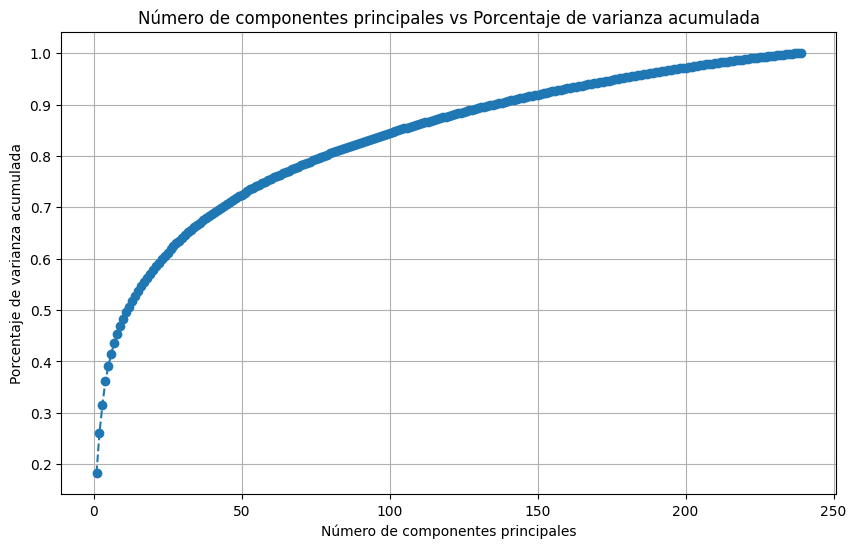

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Función para cargar y procesar imágenes
def load_and_preprocess_images(data_dir, categories, image_size=(128, 128)):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, image_size)
                flattened_image = image.flatten()
                data.append(flattened_image)
                labels.append(category)
    return np.array(data), np.array(labels)

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Cargar y procesar las imágenes
data, labels = load_and_preprocess_images(data_dir, categories)

# Realizar PCA para determinar el número de componentes principales
pca = PCA()
pca.fit(data)

# Graficar porcentaje de varianza acumulada vs número de componentes principales
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Número de componentes principales vs Porcentaje de varianza acumulada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid(True)
plt.show()

Se conoce que no hay un número "correcto" universal para el número de componentes; depende del equilibrio entre la simplicidad del modelo y la cantidad de varianza explicada. Para los siguientes modelos se tomaran 40, 50, 60, 70, 100 y 120 números de componentes principales. 

In [41]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Crear un pipeline que incluya PCA y SVM
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('pca', PCA()),
    ('svm', svm.SVC(C=0.001, gamma='scale', kernel='linear', class_weight='balanced'))
])

# Parámetros para GridSearch
param_grid = {
    'pca__n_components': [40, 50, 60, 70, 100, 120]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\n\nREPORTE DE CLASIFICACIÓN EN EL CONJUNTO DE ENTRENAMIENTO:")
print(classification_report(y_train, y_train_pred))
print("PRECISIÓN EN EL CONJUNTO DE ENTRENAMIENTO:", accuracy_score(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\n\nREPORTE DE CLASIFICACIÓN EN EL CONJUNTO DE PRUEBA:")
print(classification_report(y_test, y_pred))
print("PRECISIÓN EN EL CONJUNTO DE PRUEBA:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor conjunto de parámetros: {'pca__n_components': 60}
Mejor puntuación de validación cruzada: 0.613225371120108
Desviación estándar de la puntuación de validación cruzada: 0.08294864961053218


REPORTE DE CLASIFICACIÓN EN EL CONJUNTO DE ENTRENAMIENTO:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       105
           1       0.70      0.72      0.71        86

    accuracy                           0.73       191
   macro avg       0.73      0.73      0.73       191
weighted avg       0.73      0.73      0.73       191

PRECISIÓN EN EL CONJUNTO DE ENTRENAMIENTO: 0.7329842931937173


REPORTE DE CLASIFICACIÓN EN EL CONJUNTO DE PRUEBA:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        26
           1       0.64      0.73      0.68        22

    accuracy                           0.69        48
   macro avg       0.69   

Comparado con el resultado anterior, si bien hay una mejora, esta es mínima. 

## **Random Forest**

### **GridSearch (con Crossvalidation)**

A través de gridsearch se buscarán los mejores parámetros para la clasifficación de las imágenes:

- n_estimators: (Número de árboles en el bosque)
- max_features: (Número de características a considerar al buscar la mejor división)
- max_depth: (Profundidad máxima del árbol)
- min_samples_split: (Número mínimo de muestras requeridas para dividir un nodo)
- min_samples_leaf: (Número mínimo de muestras requeridas en cada hoja del árbol)
- bootstrap: (Método para muestrear puntos de datos (con o sin reemplazo))

In [20]:
import os
import cv2
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes, sus etiquetas y el identificador del paciente
data = []
labels = []
groups = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)
            # Extraer el identificador del paciente (asumiendo que está antes del primer guion bajo)
            patient_id = img.split('_')[0]
            groups.append(patient_id)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)
groups = np.array(groups)

# Dividir los datos en conjuntos de entrenamiento y prueba asegurando que las imágenes del mismo paciente estén en el mismo conjunto
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(data, labels, groups=groups))

X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Crear un pipeline que incluya PCA y Random Forest
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('rf', RandomForestClassifier(class_weight='balanced'))
])

# Parámetros para GridSearch
param_grid = {
    'rf__n_estimators': [40, 50],
    'rf__max_depth': [1, 2],
    'rf__min_samples_split': [4, 6, 8],
    'rf__min_samples_leaf': [2, 4, 6],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch con pesos de clase
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\nReporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejor conjunto de parámetros: {'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 4, 'rf__n_estimators': 50}
Mejor puntuación de validación cruzada: 0.6330634278002699
Desviación estándar de la puntuación de validación cruzada: 0.12913957347172234

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       107
           1       0.84      0.81      0.83        86

    accuracy                           0.85       193
   macro avg       0.85      0.85      0.85       193
weighted avg       0.85      0.85      0.85       193


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65        24
           1       0.62      0.59      0.60        22

    accuracy                          

### **PCA + GridSearch (con Crossvalidation)**

In [21]:
import os
import cv2
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes, sus etiquetas y el identificador del paciente
data = []
labels = []
groups = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)
            # Extraer el identificador del paciente (asumiendo que está antes del primer guion bajo)
            patient_id = img.split('_')[0]
            groups.append(patient_id)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)
groups = np.array(groups)

# Dividir los datos en conjuntos de entrenamiento y prueba asegurando que las imágenes del mismo paciente estén en el mismo conjunto
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(data, labels, groups=groups))

X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Crear un pipeline que incluya PCA y Random Forest
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('pca', PCA()),
    ('rf', RandomForestClassifier(class_weight='balanced', 
                                  max_depth= 2, 
                                  max_features= 'log2', 
                                  min_samples_leaf= 4, 
                                  min_samples_split= 4,
                                  n_estimators= 50))
])

# Parámetros para GridSearch
param_grid = {
    'pca__n_components': [40, 50, 60, 70, 100, 120]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch con pesos de clase
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\nReporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor conjunto de parámetros: {'pca__n_components': 40}
Mejor puntuación de validación cruzada: 0.6580296896086371
Desviación estándar de la puntuación de validación cruzada: 0.04681402348205693

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       107
           1       0.90      0.93      0.91        86

    accuracy                           0.92       193
   macro avg       0.92      0.92      0.92       193
weighted avg       0.92      0.92      0.92       193


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        24
           1       0.63      0.77      0.69        22

    accuracy                           0.67        46
   macro avg       0.68      0.68      0.67        46
weighted avg       0.69      0.67  

## **Naive Bayes**

### **GridSearch (con Crossvalidation)**

In [18]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes, sus etiquetas y el identificador del paciente
data = []
labels = []
groups = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)
            # Extraer el identificador del paciente (asumiendo que está antes del primer guion bajo)
            patient_id = img.split('_')[0]
            groups.append(patient_id)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)
groups = np.array(groups)

# Dividir los datos en conjuntos de entrenamiento y prueba asegurando que las imágenes del mismo paciente estén en el mismo conjunto
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(data, labels, groups=groups))

X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Crear un pipeline que incluya PCA y Gaussian Naive Bayes
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('nb', GaussianNB())
])

# Parámetros para GridSearch
param_grid = {
    'nb__var_smoothing': np.logspace(0, -9, num=10)
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch con pesos de clase
grid_search.fit(X_train, y_train, nb__sample_weight=np.array([class_weights_dict[i] for i in y_train]))

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\nReporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor conjunto de parámetros: {'nb__var_smoothing': 1.0}
Mejor puntuación de validación cruzada: 0.5755735492577598
Desviación estándar de la puntuación de validación cruzada: 0.0925504459264622

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       107
           1       0.73      0.41      0.52        86

    accuracy                           0.67       193
   macro avg       0.69      0.64      0.63       193
weighted avg       0.68      0.67      0.65       193


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.61      0.96      0.74        24
           1       0.88      0.32      0.47        22

    accuracy                           0.65        46
   macro avg       0.74      0.64      0.60        46
weighted avg       0.73      0.65 

### **PCA + GridSearch (con Crossvalidation)**

In [19]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes, sus etiquetas y el identificador del paciente
data = []
labels = []
groups = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)  # Usar índice de categoría como etiqueta
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(class_num)
            # Extraer el identificador del paciente (asumiendo que está antes del primer guion bajo)
            patient_id = img.split('_')[0]
            groups.append(patient_id)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)
groups = np.array(groups)

# Dividir los datos en conjuntos de entrenamiento y prueba asegurando que las imágenes del mismo paciente estén en el mismo conjunto
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(data, labels, groups=groups))

X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Crear un pipeline que incluya PCA y Gaussian Naive Bayes
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usar MinMaxScaler para normalizar los datos
    ('pca', PCA()),
    ('nb', GaussianNB(var_smoothing=1.0))
])

# Parámetros para GridSearch
param_grid = {
    'pca__n_components': [40, 50, 60, 70, 100, 120]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch con pesos de clase
grid_search.fit(X_train, y_train, nb__sample_weight=np.array([class_weights_dict[i] for i in y_train]))

# Mejor modelo y parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print("Mejor conjunto de parámetros:", best_params)
print("Mejor puntuación de validación cruzada:", best_score)
print("Desviación estándar de la puntuación de validación cruzada:", std_dev)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_

# Reporte de clasificación en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("\nReporte de clasificación en el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred))

# Reporte de clasificación en el conjunto de prueba
y_pred = best_model.predict(X_test)
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor conjunto de parámetros: {'pca__n_components': 60}
Mejor puntuación de validación cruzada: 0.5908232118758435
Desviación estándar de la puntuación de validación cruzada: 0.09040082816036368

Reporte de clasificación en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75       107
           1       0.76      0.37      0.50        86

    accuracy                           0.67       193
   macro avg       0.70      0.64      0.63       193
weighted avg       0.70      0.67      0.64       193


Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.59      0.96      0.73        24
           1       0.86      0.27      0.41        22

    accuracy                           0.63        46
   macro avg       0.72      0.62      0.57        46
weighted avg       0.72      0.63  

## **Resultados**

| **Modelo**        | **Gridsearch (Crossvalidation)** | **PCA + Gridsearch (Crossvalidation)** |
|-------------------|-----------------------------------|----------------------------------------|
| **SVM**           | 0.56 ± 0.09                       | 0.61 ± 0.08                            |
| **Random Forest** | 0.63 ± 0.13                       | 0.66 ± 0.05                            |
| **Naive Bayes**   | 0.58 ± 0.09                       | 0.59 ± 0.09                            |
